In [2]:
import ROOT as r
import numpy as np
import math

Welcome to JupyROOT 6.22/00


In [3]:
f = r.TFile("samples/ZZTo4mu_skim.root")
f.ls()
t = f.Get("Events")

TFile**		samples/ZZTo4mu_skim.root	
 TFile*		samples/ZZTo4mu_skim.root	
  KEY: TTree	Events;2	Events
  KEY: TTree	Events;1	Events


In [9]:
c = r.TCanvas('c1','c1',800,600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [4]:
nEntries = t.GetEntries()
print(nEntries)

98502


In [19]:
xsec = 7.6865000E-02 
nEvents = 1499064
lumi = (4.42+7.06)*1000
print(lumi)
weight = lumi * xsec / nEvents
print(weight)

11480.0
0.000588640778512


In [7]:
## write a function that computes the invariant mass given the event
## the list version
def invmass(Leptons):
    m = 0
    px = 0
    py = 0
    pz = 0
    e = 0
    for lep in Leptons:
        px += lep['pt']*math.cos(lep['phi'])
        py += lep['pt']*math.sin(lep['phi'])
        theta = 2.*math.atan(np.exp(-lep['eta'])) 
        pz += lep['pt']/math.tan(theta)
        e += np.sqrt(lep['pt']**2 + (lep['pt']/np.tan(theta))**2 + lep['mass']**2)
    
    m = np.sqrt(e**2 - px**2 - py**2 - pz**2)    
    ## OR in the massless muon limit, the formula can be more compact:
    #m  = np.sqrt(2*pt[0]*pt[1]*(np.cosh(eta[0]-eta[1])-np.cos(phi[0]-phi[1])))
    return m

In [17]:
#Creating a histogram for 4u invmass
h_ZZto4mu = r.TH1F('ZZto4mu','ZZto4mu',65,70,200)
h_ZZto4mu.SetFillColor(0)
h_ZZto4mu.SetLineColor(r.kRed)
h_ZZto4mu.Draw()
c.Update()

Warning in <TFile::Append>: Replacing existing TH1: ZZto4mu (Potential memory leak).


In [11]:
def check(Leptons):
    #positive    
    for i in range(2):
        Pair = list()
        AntiPair = list()
        #negative
        Pair.append(Leptons[i])
        AntiPair.append(Leptons[1-i])
        for j in range(2,4):
            Pair.append(Leptons[j])
            AntiPair.append(Leptons[5-j])
            Zmass1 = invmass(Pair)
            Zmass2 = invmass(AntiPair)
            Lpt1 = max(Leptons[i]['pt'],Leptons[j]['pt'])
            Lpt2 = min(Leptons[i]['pt'],Leptons[j]['pt'])
            if (Lpt1>20)and(Lpt2>10)and(Zmass1>=40)and(Zmass1<=120)and(Zmass2>=12)and(Zmass2<=120): 
                return True
            Pair.remove(Leptons[j])
            AntiPair.remove(Leptons[5-j])
    return False  

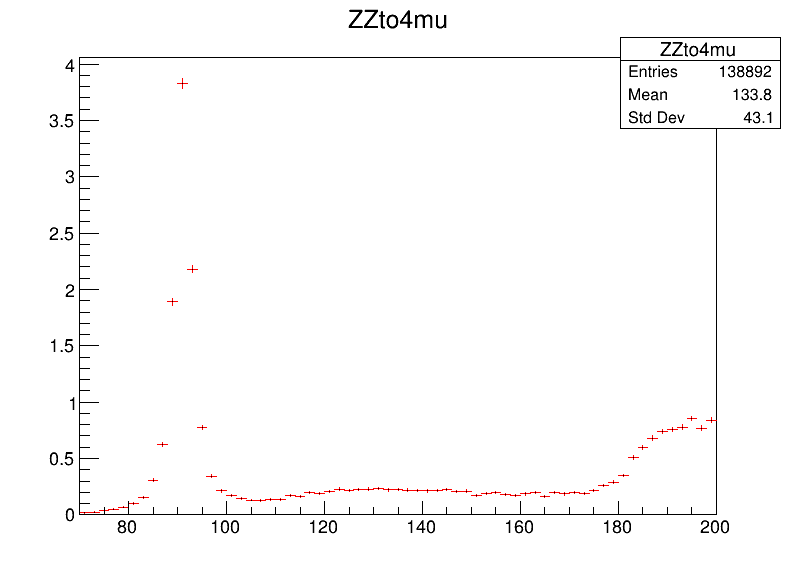

In [20]:
#selecting the 4u events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if Mrellso >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy / t.Muon_dxyErr[j]) ** 2 + (Mdz / t.Muon_dzErr[j]) ** 2)
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)
    if nGoodMuon != 4: continue 
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_ZZto4mu.Fill(invmass(Leptons),weight)  
c.Update()
c.Draw()